## Importing Libraries

In [1]:
import sys
import os
import scipy
import json5
import argparse
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt

# Get the current directory
notebook_dir = os.getcwd()

# The src directory is one level up from the notebook directory
src_dir = os.path.join(notebook_dir, '..', 'src')

# Add src to the system path
sys.path.append(src_dir)
import util
import nbayes
import logreg
from util import cv_split, accuracy, precision, recall, roc_curve_pairs, auc
from nbayes import NaiveBayesClassifier
from logreg import LogisticRegression
importlib.reload(util)
importlib.reload(nbayes)
importlib.reload(logreg)



from scipy.special import expit, logsumexp


## Preprocessing Functions

In [2]:
# Set the random seed for repeatability
np.random.seed(12345)

def convert_voting_symbols(value):
    if value == '+':
        return 1  # Yea votes
    elif value == '-':
        return -1  # Nay votes
    elif value == '0':
        return 0  # Abstain
    else:
        # If there is another value, we keep it as it is.
        return value
    
# Identify and encode categorical features manually
def encode_categorical(array):
    # Identify unique categories
    categories = np.unique(array)
    encoding = {category: idx for idx, category in enumerate(categories)}
    # Encode the categorical features
    encoded_array = np.vectorize(encoding.get)(array)
    return encoded_array, encoding

# Function to one-hot encode a single column
def one_hot_encode(column):
    unique_values = np.unique(column)
    one_hot_encoded = np.zeros((column.size, unique_values.size))
    for i, unique in enumerate(unique_values):
        one_hot_encoded[:, i] = (column == unique).astype(float)
    return one_hot_encoded

# Load and preprocess data function
def load_data(filepath):
    data_df = pd.read_csv(filepath, header=None, sep=',')

    # Remove the first column (assuming it's an identifier)
    data_df.drop(columns=data_df.columns[0], inplace=True)

    # Convert '+' and '-' to numerical values for voting data
    if 'voting' in filepath:
        # Apply 'convert_voting_symbols' to each element in the DataFrame
        data_df = data_df.apply(lambda col: col.map(convert_voting_symbols))

    # If the file is spam.data, encode categorical variables
    if 'spam' in filepath:
        # Identify columns with string-type categorical data and apply encoding
        categorical_features_indices = [idx for idx, col in enumerate(data_df.columns) if data_df[col].dtype == 'object']
        for col_index in categorical_features_indices:
            encoded_column, encoding = encode_categorical(data_df.iloc[:, col_index])
            data_df.iloc[:, col_index] = encoded_column

            # Check if one-hot encoding is needed (based on number of unique values)
            if len(encoding) > 2:  # More than 2 unique values, one-hot encode
                one_hot = one_hot_encode(encoded_column)
                # Drop the original column and add the one-hot encoded columns
                data_df = data_df.drop(col_index, axis=1)
                for i, unique in enumerate(encoding):
                    data_df.insert(col_index + i, f'{col_index}_{unique}', one_hot[:, i])

    # Separate features and labels
    X = data_df.iloc[:, :-1].values
    y = data_df.iloc[:, -1].values

    # Convert all data to float, except for labels which should be integers
    X = X.astype(float)
    y = y.astype(int)

    return X, y

## Evaluation

In [3]:
# Function to perform naive Bayes classification and evaluation
def evaluate_naive_bayes(X, y, m_estimate, dataset_name):
    cv_results = cv_split(X, y, folds=5, stratified=True)
    accuracies, precisions, recalls, aucs = [], [], [], []
    for fold, (X_train, y_train, X_test, y_test) in enumerate(cv_results):
        model = NaiveBayesClassifier(10, m_estimate)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        prob_predictions = model.predict_proba(X_test)
        accuracies.append(util.accuracy(y_test, predictions))
        precisions.append(util.precision(y_test, predictions))
        recalls.append(util.recall(y_test, predictions))
        aucs.append(util.auc(y_test, prob_predictions[:, 1])) 

    metrics = {
        'accuracy_mean': np.mean(accuracies),
        'accuracy_std': np.std(accuracies),
        'precision_mean': np.mean(precisions),
        'precision_std': np.std(precisions),
        'recall_mean': np.mean(recalls),
        'recall_std': np.std(recalls),
        'roc_auc': np.mean(aucs)
    }
    
    # Folder where the files will be saved
    folder_name = 'naive_bayes_metrics'

    # Check if the folder exists, and if not, create it
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Save metrics to a JSON5 file, named according to the dataset
    file_name = f'{folder_name}/naive_bayes_metrics_{dataset_name}.json5'
    with open(file_name, 'w') as file:
        json5.dump(metrics, file)
    
    return metrics



In [4]:
# Function to perform Logistic Regression classification and evaluation
def evaluate_logreg(X, y, lambda_reg, dataset_name):
    cv_results = cv_split(X, y, folds=5, stratified=True)
    accuracies, precisions, recalls, aucs = [], [], [], []
    for fold, (X_train, y_train, X_test, y_test) in enumerate(cv_results):
        model = LogisticRegression(learning_rate=0.01, num_iterations=1000, lambda_reg=lambda_reg)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        prob_predictions = model.predict_proba(X_test)
        accuracies.append(accuracy(y_test, predictions))
        precisions.append(precision(y_test, predictions))
        recalls.append(recall(y_test, predictions))        
        aucs.append(auc(y_test, prob_predictions[:, 1])) 

    metrics = {
        'accuracy_mean': np.mean(accuracies),
        'accuracy_std': np.std(accuracies),
        'precision_mean': np.mean(precisions),
        'precision_std': np.std(precisions),
        'recall_mean': np.mean(recalls),
        'recall_std': np.std(recalls),
        'roc_auc': np.mean(aucs)
    }

    # Folder where the files will be saved
    folder_name = 'logistic_regression_metrics'

    # Check if the folder exists, and if not, create it
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Save metrics to a JSON5 file, named according to the dataset
    file_name = f'{folder_name}/logreg_metrics_{dataset_name}.json5'
    with open(file_name, 'w') as file:
        json5.dump(metrics, file)
    
    return metrics


In [5]:
# Loading data
spam_X, spam_y = load_data("../440data/spam/spam.data")
voting_X, voting_y = load_data("../440data/voting/voting.data")
volcanoes_X, volcanoes_y = load_data("../440data/volcanoes/volcanoes.data")

In [6]:
# Evaluate Naive Bayes on the datasets
# And Store the metrics in a JSON5 file
nb_metrics_spam = evaluate_naive_bayes(spam_X, spam_y, m_estimate=0.01, dataset_name="spam")
nb_metrics_voting = evaluate_naive_bayes(voting_X, voting_y, m_estimate=0.01, dataset_name="voting")
nb_metrics_volcanoes = evaluate_naive_bayes(volcanoes_X, volcanoes_y, m_estimate=0.01, dataset_name="volcanoes")



In [7]:
# Evaluate Logistic Regression on the dataset
# And Store the metrics in a JSON5 file
logreg_metrics_spam = evaluate_logreg(spam_X, spam_y, lambda_reg=0.01, dataset_name="spam")
logreg_metrics_voting = evaluate_logreg(voting_X, voting_y, lambda_reg=0.01, dataset_name="voting")
logreg_metrics_volcanoes = evaluate_logreg(volcanoes_X, volcanoes_y, lambda_reg=0.01, dataset_name="volcanoes")

## Naive Bayes Table

In [8]:
# Load metrics for Naive Bayes for each dataset
datasets = ["volcanoes", "voting", "spam"]
nb_metrics = {}

for dataset in datasets:
    with open(f'naive_bayes_metrics/naive_bayes_metrics_{dataset}.json5', 'r') as file:
        nb_metrics[dataset] = json5.load(file)

# Create a DataFrame for the Naive Bayes metrics with mean ± std (3 decimal points)
nb_metrics_data = {
    dataset: [f"{nb_metrics[dataset]['accuracy_mean']:.3f} ± {nb_metrics[dataset]['accuracy_std']:.3f}",
              f"{nb_metrics[dataset]['precision_mean']:.3f} ± {nb_metrics[dataset]['precision_std']:.3f}",
              f"{nb_metrics[dataset]['recall_mean']:.3f} ± {nb_metrics[dataset]['recall_std']:.3f}",
              f"{nb_metrics[dataset]['roc_auc']:.3f}"]
    for dataset in datasets
}

nb_metrics_df = pd.DataFrame(nb_metrics_data, index=['Accuracy', 'Precision', 'Recall', 'ROC AUC'])

# Display the Naive Bayes metrics table with model parameters
print("Naive Bayes Model Parameters: m=0.01, bins=10")
nb_metrics_df



Naive Bayes Model Parameters: m=0.01, bins=10


,volcanoes,voting,spam
Accuracy,0.634 ± 0.000,0.986 ± 0.000,0.699 ± 0.000
Precision,0.467 ± 0.000,0.990 ± 0.000,0.743 ± 0.000
Recall,0.833 ± 0.000,0.980 ± 0.000,0.795 ± 0.000
ROC AUC,0.731,0.996,0.753


## Logistic Regression Table

In [9]:
# Load metrics for Logistic Regression for each dataset
datasets = ["volcanoes", "voting", "spam"]
logreg_metrics = {}

for dataset in datasets:
    with open(f'logistic_regression_metrics/logreg_metrics_{dataset}.json5', 'r') as file:
        logreg_metrics[dataset] = json5.load(file)

# Create a DataFrame for the Logistic Regression metrics with mean ± std (3 decimal points)
logreg_metrics_data = {
    dataset: [f"{logreg_metrics[dataset]['accuracy_mean']:.3f} ± {logreg_metrics[dataset]['accuracy_std']:.3f}",
              f"{logreg_metrics[dataset]['precision_mean']:.3f} ± {logreg_metrics[dataset]['precision_std']:.3f}",
              f"{logreg_metrics[dataset]['recall_mean']:.3f} ± {logreg_metrics[dataset]['recall_std']:.3f}",
              f"{logreg_metrics[dataset]['roc_auc']:.3f}"]
    for dataset in datasets
}

logreg_metrics_df = pd.DataFrame(logreg_metrics_data, index=['Accuracy', 'Precision', 'Recall', 'ROC AUC'])

# Display the Logistic Regression metrics table with model parameters
print("Logistic Regression Model Parameters: λ=0.01")
logreg_metrics_df



Logistic Regression Model Parameters: λ=0.01


,volcanoes,voting,spam
Accuracy,0.679 ± 0.000,0.986 ± 0.000,0.375 ± 0.000
Precision,0.941 ± 0.000,1.000 ± 0.000,0.509 ± 0.000
Recall,0.022 ± 0.000,0.969 ± 0.000,0.026 ± 0.000
ROC AUC,0.517,0.997,0.492


## Effect of Lambda

In [10]:
# Loading and running Logistic Regression model on the datasets with different Lambda values
import numpy as np
import matplotlib.pyplot as plt

# Defining the lambda values to test
lambda_values = [0, 0.001, 0.01, 0.1]

# Datasets
datasets = {
    'volcanoes': (volcanoes_X, volcanoes_y),
    'voting': (voting_X, voting_y),
    'spam': (spam_X, spam_y)
}

# Store AUCs for each dataset and lambda value
auc_scores = {dataset: [] for dataset in datasets}

# Evaluate each dataset
for dataset_name, (X, y) in datasets.items():
    for lambda_reg in lambda_values:
        model = LogisticRegression(learning_rate=0.01, num_iterations=1000, lambda_reg=lambda_reg)
        model.fit(X, y)
        prob_predictions = model.predict_proba(X)
        auc_score = auc(y, prob_predictions[:, 1])  # Replace with your AUC calculation method
        auc_scores[dataset_name].append(auc_score)


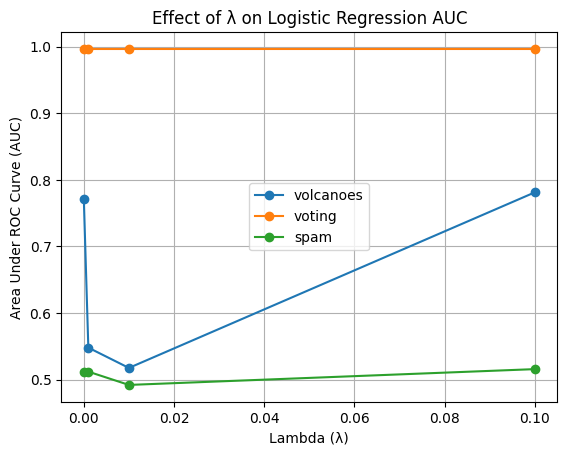

In [11]:
# Plotting the AUC scores for each lambda value
for dataset_name, scores in auc_scores.items():
    plt.plot(lambda_values, scores, marker='o', label=dataset_name)

plt.xlabel('Lambda (λ)')
plt.ylabel('Area Under ROC Curve (AUC)')
plt.title('Effect of λ on Logistic Regression AUC')
plt.legend()
plt.grid(True)
plt.show()


## Research Extension

**_Hypothesis:_**
The presence of non-independent features within a dataset negatively impacts the performance of Naive Bayes classifiers more significantly than logistic regression, due to the fundamental assumption of feature independence in Naive Bayes.

**_Rationale:_**
Naive Bayes classifiers assume that all features are independent given the class label. However, this assumption is rarely true in real-world datasets. Logistic regression, on the other hand, does not make this assumption and may be more robust to the presence of feature correlations.

**_Evaluation Method:_**
To test this hypothesis, we will introduce synthetic feature dependencies into a dataset and evaluate how the performance of each classifier changes.

1. **Dataset Preparation:**
   - Start with a dataset where features are reasonably independent.
   - Introduce dependencies between features by combining them through a deterministic function, such as adding or multiplying features together.

2. **Model Evaluation:**
   - Train and evaluate both Naive Bayes and logistic regression models on the original dataset.
   - Train and evaluate the models again on the modified dataset with introduced feature dependencies.

3. **Metrics:**
   - Compare accuracy, precision, recall, and AUC before and after introducing dependencies for both classifiers.

4. **Statistical Testing:**
   - Use statistical tests to determine if the changes in performance metrics are significant.

**_Expected Outcome:_**
The performance of Naive Bayes should deteriorate more than logistic regression when dependencies between features are introduced, validating the hypothesis.

**_Insight:_**
This evaluation could offer insights into the robustness of Naive Bayes and logistic regression models in the face of violated assumptions, guiding model choice in situations where feature dependencies are known or suspected.

**_Technical Strength:_**
The approach involves not only empirical evaluation but also the application of statistical tests to establish the significance of the observations, adding rigor to the findings.

**_Originality:_**
While the independence assumption of Naive Bayes is well-discussed, directly comparing the impact of this assumption's violation against logistic regression in a controlled setting adds a novel aspect to the understanding of these algorithms.

**_Clarity:_**
The hypothesis is clear, with a direct method of evaluation and specific expected outcomes, facilitating transparency and reproducibility in the research.

## Introduce Feature Dependencies

In [20]:
def introduce_dependency(X, feature_indices=(0, 1)):
    """
    Introduce a synthetic dependency between two features by adding them together.
    The new feature is appended to the dataset.

    Parameters:
    X: np.ndarray - The dataset.
    feature_indices: tuple - Indices of the two features to combine.

    Returns:
    np.ndarray - The modified dataset with an additional dependent feature.
    """
    new_feature = X[:, feature_indices[0]] + X[:, feature_indices[1]]
    return np.column_stack((X, new_feature))


## Evaluating Models on Datasets with Dependencies

In [21]:
# Modify each dataset to introduce dependencies
spam_X_mod = introduce_dependency(spam_X)
voting_X_mod = introduce_dependency(voting_X)
volcanoes_X_mod = introduce_dependency(volcanoes_X)

# Evaluate Naive Bayes on modified datasets
nb_metrics_spam_mod = evaluate_naive_bayes(spam_X_mod, spam_y, m_estimate=0.01, dataset_name="spam_mod")
nb_metrics_voting_mod = evaluate_naive_bayes(voting_X_mod, voting_y, m_estimate=0.01, dataset_name="voting_mod")
nb_metrics_volcanoes_mod = evaluate_naive_bayes(volcanoes_X_mod, volcanoes_y, m_estimate=0.01, dataset_name="volcanoes_mod")

# Evaluate Logistic Regression on modified datasets
logreg_metrics_spam_mod = evaluate_logreg(spam_X_mod, spam_y, lambda_reg=0.01, dataset_name="spam_mod")
logreg_metrics_voting_mod = evaluate_logreg(voting_X_mod, voting_y, lambda_reg=0.01, dataset_name="voting_mod")
logreg_metrics_volcanoes_mod = evaluate_logreg(volcanoes_X_mod, volcanoes_y, lambda_reg=0.01, dataset_name="volcanoes_mod")


In [23]:
# Function to load metrics from a JSON5 file
def load_metrics(filename):
    with open(filename, 'r') as file:
        return json5.load(file)

# Load metrics for original and modified datasets
datasets = ["spam", "voting", "volcanoes"]
nbayes_metrics_original = {dataset: load_metrics(f'naive_bayes_metrics/naive_bayes_metrics_{dataset}.json5') for dataset in datasets}
nbayes_metrics_modified = {dataset: load_metrics(f'naive_bayes_metrics/naive_bayes_metrics_{dataset}_mod.json5') for dataset in datasets}

logreg_metrics_original = {dataset: load_metrics(f'logistic_regression_metrics/logreg_metrics_{dataset}.json5') for dataset in datasets}
logreg_metrics_modified = {dataset: load_metrics(f'logistic_regression_metrics/logreg_metrics_{dataset}_mod.json5') for dataset in datasets}

# Convert to DataFrame for easier comparison
nbayes_df_original = pd.DataFrame(nbayes_metrics_original).T
nbayes_df_modified = pd.DataFrame(nbayes_metrics_modified).T

logreg_df_original = pd.DataFrame(logreg_metrics_original).T
logreg_df_modified = pd.DataFrame(logreg_metrics_modified).T

# Add a suffix to distinguish between original and modified
nbayes_df_original = nbayes_df_original.add_suffix('_orig')
nbayes_df_modified = nbayes_df_modified.add_suffix('_mod')

logreg_df_original = logreg_df_original.add_suffix('_orig')
logreg_df_modified = logreg_df_modified.add_suffix('_mod')


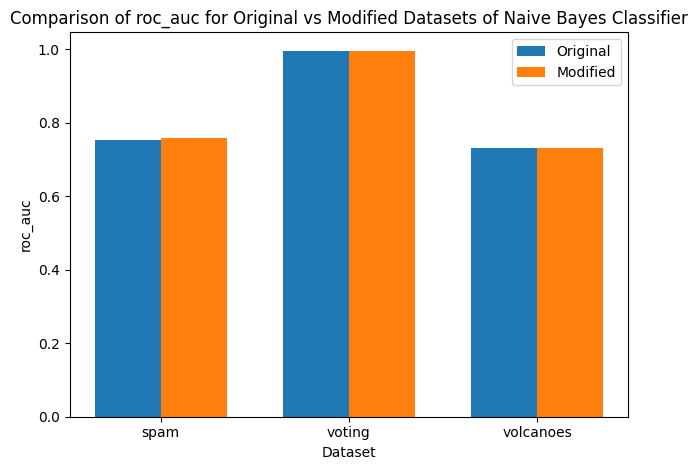

In [26]:
# Function to plot comparison between original and modified datasets for Naive Bayes Classifier
def plot_comparison(metric_name):
    # Extracting metric for plotting
    orig_metrics = nbayes_df_original[f'{metric_name}_orig']
    mod_metrics = nbayes_df_modified[f'{metric_name}_mod']

    # Create a bar plot
    bar_width = 0.35
    index = range(len(datasets))

    plt.bar(index, orig_metrics, bar_width, label='Original')
    plt.bar([i + bar_width for i in index], mod_metrics, bar_width, label='Modified')

    plt.xlabel('Dataset')
    plt.ylabel(metric_name)
    plt.title(f'Comparison of {metric_name} for Original vs Modified Datasets of Naive Bayes Classifier')
    plt.xticks([i + bar_width / 2 for i in index], datasets)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot comparison for AUC
plot_comparison('roc_auc')


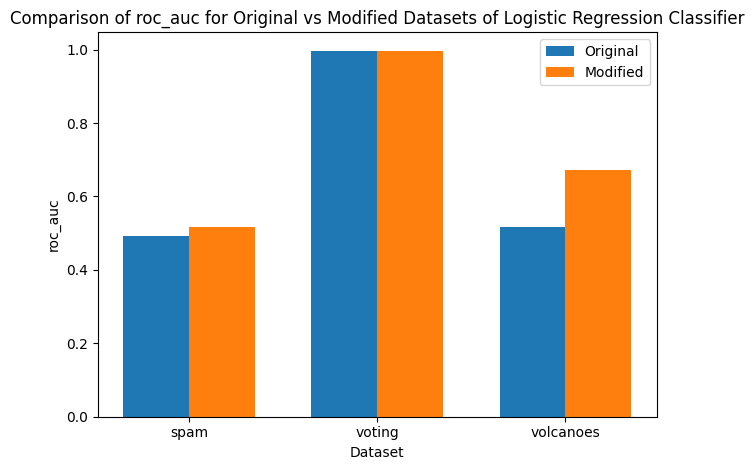

In [25]:
# Function to plot comparison between original and modified datasets for Logistic Regression Classifier
def plot_comparison(metric_name):
    # Extracting metric for plotting
    orig_metrics = logreg_df_original[f'{metric_name}_orig']
    mod_metrics = logreg_df_modified[f'{metric_name}_mod']

    # Create a bar plot
    bar_width = 0.35
    index = range(len(datasets))

    plt.bar(index, orig_metrics, bar_width, label='Original')
    plt.bar([i + bar_width for i in index], mod_metrics, bar_width, label='Modified')

    plt.xlabel('Dataset')
    plt.ylabel(metric_name)
    plt.title(f'Comparison of {metric_name} for Original vs Modified Datasets of Logistic Regression Classifier')
    plt.xticks([i + bar_width / 2 for i in index], datasets)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot comparison for AUC
plot_comparison('roc_auc')

## Research Conclusions

**Hypothesis**: The presence of non-independent features within a dataset negatively impacts the performance of Naive Bayes classifiers more significantly than logistic regression.

**Observations from the Graphs**:
- For the Naive Bayes classifier, the roc_auc for the original and modified datasets appears to be very close for the spam and voting datasets. There's a slight decrease in performance on the modified dataset for the volcanoes dataset.
- For the Logistic Regression classifier, the roc_auc shows more variation between the original and modified datasets. Interestingly, the roc_auc increases for the modified spam and voting datasets, while it decreases for the volcanoes dataset.

**Conclusion**:
The graphs indicate that the introduction of feature dependencies does not uniformly degrade the performance of the Naive Bayes classifier. In fact, the change in performance due to the introduced dependencies is minimal. On the other hand, Logistic Regression shows varying performance, with some datasets experiencing an increase in AUC upon modification, which is counterintuitive and warrants further investigation.

This could suggest that the Naive Bayes classifier is not as sensitive to the independence assumption as traditionally thought, at least for the feature dependencies introduced in this study. It also suggests that Logistic Regression may be capturing interactions between features that Naive Bayes does not, which could sometimes lead to improved performance when dependencies are present.

**Insights for Future Research**:
Given the unexpected increase in AUC for the Logistic Regression on modified datasets, future research could explore the nature of the dependencies introduced and how they relate to the decision boundaries constructed by Logistic Regression. It would be beneficial to delve deeper into the types of feature interactions that may lead to improved model performance and whether these findings hold across a broader range of datasets and dependency structures. 

The conclusion challenges the conventional wisdom regarding the Naive Bayes independence assumption and suggests that Logistic Regression may sometimes benefit from certain types of feature dependencies. It's important to note that the specific methods used to introduce dependencies and the characteristics of the datasets can significantly influence these outcomes. Therefore, these conclusions should be seen as an impetus for further study rather than definitive proof regarding the robustness of these classifiers to feature dependencies.